# House Price Prediction


## Project Guide

- [Project Overview](#overview)
- [Data Exploration & Preparation](#exploration)
- [Modeling with Scikit Learn](#sklearn)
- [Conclusion](#conclusion)

<a id = "overview"></a>
## Project Overview

This project uses [Kaggle's House Prices Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) to discuss regression models for predicting continuous outputs. Before using `scikit-learn` package for modeling, the workbook will also include data exploration/cleaing and try to apply linear algebra algorithm with `numpy` package to reproduce modeling functions under the hood.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.2, 10.0)

In [3]:
### Read in the data
df = pd.read_csv('../project-house-price-prediction/data/train.csv')
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

#### Observe missing values
Alley, FireplaceQu, PoolQC, Fence, and MiscFeature have high portion of missing values.

In [4]:
# There are some columns with high percentage of missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

#### Observe the distribution of numeric columns
Some actions from observation:
1. Id should be removed from the dataset
2. TotalBsmtSF should be removed to avoid multicollinearity with BsmtFinSF1, bsmtFinSF2, and BsmtUnfSF
3. Transform YearBuilt, YearRemodAdd, and GarageYrBlt to new variables Age of Building/Remodel/Garage.
4. At first glance, MoSold and YrSold don't seem to be very relevant to price. The relationship between these two variable with SalePrice will be examined later.
5. Fill in the missing value in LotFrontage and MasVnrArea with mean value

In [5]:
df_numeric = df.select_dtypes(include = ['int64', 'float64'])
df_numeric.describe().T

count           mean           std      min        25%  \
Id             1460.0     730.500000    421.610009      1.0     365.75   
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   
1stFlrSF       1460.0    1162.626712    386.587738    334.0     882.00   
2ndFlrSF       1460.0     346.992466    436.528436      0.0       0.00   
LowQualFinSF   1460.0       5.844521     48.623081      0.0       0.00   
GrLivArea      1460.0    1515.463699    525.480383    334.0    1129.50   
BsmtFullBath   1460.0       0.425342      0.518911      0.0       0.00   
BsmtHalfBath   1460.0       0.057534      0.238753      0.0       0.00   
FullBath       1460.0       1.565068      0.550916      0.0       1.00   
HalfBath       1460.0       0.382877      0.502885      0.0       0.00   
BedroomAbvGr   1460.0       2.866438      0.815778      0.0       2.00   
KitchenAbvGr   1460.0       1.046575      0.220338      0.0       1.00   
TotRmsAbvGrd   1460.0       6.517808      1.625393      2.0       5.00   
Fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
GarageYrBlt    1379.0    1978.506164     24.689725   1900.0    1961.00   
GarageCars     1460.0       1.767123      0.747315      0.0       1.00   
GarageArea     1460.0     472.980137    213.804841      0.0     334.50   
WoodDeckSF     1460.0      94.244521    125.338794      0.0       0.00   
OpenPorchSF    1460.0      46.660274     66.256028      0.0       0.00   
EnclosedPorch  1460.0      21.954110     61.119149      0.0       0.00   
3SsnPorch      1460.0       3.409589     29.317331      0.0       0.00   
ScreenPorch    1460.0      15.060959     55.757415      0.0       0.00   
PoolArea       1460.0       2.758904     40.177307      0.0       0.00   
MiscVal        1460.0      43.489041    496.123024      0.0       0.00   
MoSold         1460.0       6.321918      2.703626      1.0       5.00   
YrSold         1460.0    2007.815753      1.328095   2006.0    2007.00   
SalePrice      1460.0  180921.195890  79442.502883  34900.0  129975.00   

                    50%        75%       max  
Id                730.5    1095.25    1460.0  
MSSubClass         50.0      70.00     190.0  
LotFrontage        69.0      80.00     313.0  
LotArea          9478.5   11601.50  215245.0  
OverallQual         6.0       7.00      10.0  
OverallCond         5.0       6.00       9.0  
YearBuilt        1973.0    2000.00    2010.0  
YearRemodAdd     1994.0    2004.00    2010.0  
MasVnrArea          0.0     166.00    1600.0  
BsmtFinSF1        383.5     712.25    5644.0  
BsmtFinSF2          0.0       0.00    1474.0  
BsmtUnfSF         477.5     808.00    2336.0  
TotalBsmtSF       991.5    1298.25    6110.0  
1stFlrSF         1087.0    1391.25    4692.0  
2ndFlrSF            0.0     728.00    2065.0  
LowQualFinSF        0.0       0.00     572.0  
GrLivArea        1464.0    1776.75    5642.0  
BsmtFullBath        0.0       1.00       3.0  
BsmtHalfBath        0.0       0.00       2.0  
FullBath            2.0       2.00       3.0  
HalfBath            0.0       1.00       2.0  
BedroomAbvGr        3.0       3.00       8.0  
KitchenAbvGr        1.0       1.00       3.0  
T

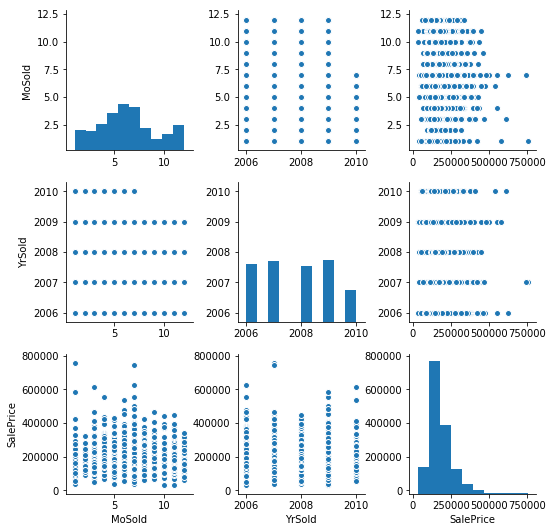

In [6]:
# MoSold and YrSold doesn't seem to be very indicative of SalesPrice
sns.pairplot(df[['MoSold', 'YrSold', 'SalePrice']])
plt.show()

#### Top 10 numeric variables with high correlation with price

In [158]:
top10_corr = df_numeric.corr()[['SalePrice']].sort_values(['SalePrice'], ascending = False)[:11].drop(['SalePrice'])

SalePrice
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
FullBath       0.560664
TotRmsAbvGrd   0.533723
YearBuilt      0.522897
YearRemodAdd   0.507101

In [164]:
df_numeric_top10 = df_numeric.loc[: , list(top10_corr.index)]
df_numeric_top10.head()

OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  1stFlrSF  \
0            7       1710           2         548          856       856   
1            6       1262           2         460         1262      1262   
2            7       1786           2         608          920       920   
3            7       1717           3         642          756       961   
4            8       2198           3         836         1145      1145   

   FullBath  TotRmsAbvGrd  YearBuilt  YearRemodAdd  
0         2             8       2003          2003  
1         2             6       1976          1976  
2         2             6       2001          2002  
3         1             7       1915          1970  
4         2             9       2000          2000

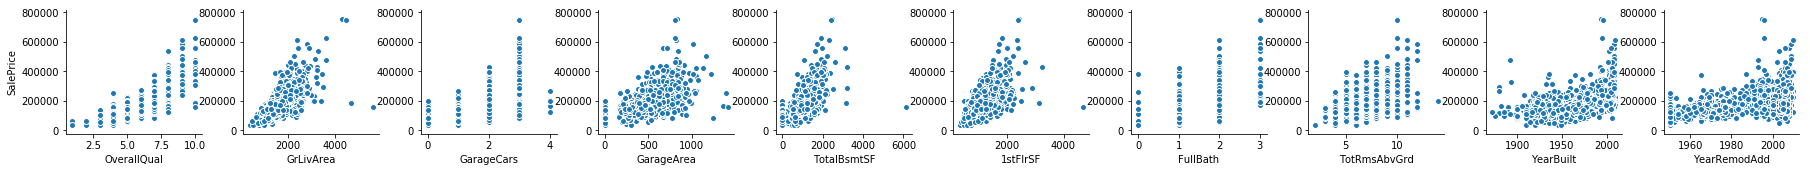

In [194]:
pp = sns.pairplot(data=df_numeric,
                  y_vars=['SalePrice'],
                  x_vars=list(top10_corr.index))

In [191]:
for i in range(2, 60):
    topN_corr = df_numeric.corr()[['SalePrice']].sort_values(['SalePrice'], ascending = False)[:i].drop(['SalePrice'])
    df_topN = df_numeric.loc[: , list(topN_corr.index)]
    df_topN = df_topN.fillna(df_topN.mean())
    X_train, X_test, y_train, y_test = train_test_split(df_topN, 
                                                        df[['SalePrice']], 
                                                        test_size = 0.3, random_state = 42)
    ridge = Ridge(alpha=0.1, normalize=True)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    
    print("Top {} Result - R-squared: {}; RMSE:, {}".format(i,
                                                            ridge.score(X_test, y_test), 
                                                            np.sqrt(mean_squared_error(y_test, y_pred))))

Top 2 Result - R-squared: 0.6320219767201622; RMSE:, 50673.317913985215
Top 3 Result - R-squared: 0.7366117992701924; RMSE:, 42871.29062925094
Top 4 Result - R-squared: 0.7536072597404939; RMSE:, 41465.06533873543
Top 5 Result - R-squared: 0.7583131407836255; RMSE:, 41067.18354597498
Top 6 Result - R-squared: 0.7887066352697614; RMSE:, 38398.24097731498
Top 7 Result - R-squared: 0.790378565044473; RMSE:, 38246.01975921556
Top 8 Result - R-squared: 0.7892094630380379; RMSE:, 38352.52443893771
Top 9 Result - R-squared: 0.7888408046426466; RMSE:, 38386.04777374343
Top 10 Result - R-squared: 0.7933295729714777; RMSE:, 37975.85571673656
Top 11 Result - R-squared: 0.7955622062584464; RMSE:, 37770.17464889633
Top 12 Result - R-squared: 0.7955302765680073; RMSE:, 37773.124061715804
Top 13 Result - R-squared: 0.8050155623562223; RMSE:, 36886.57869472721
Top 14 Result - R-squared: 0.8057439335609009; RMSE:, 36817.618679693136
Top 15 Result - R-squared: 0.8113729899020102; RMSE:, 36280.2558192389

#### Observe the correlation of numeric variables
1. GarageYrBlt and YearBuilt are highly correlated. GarageYrBlt could be removed.
2. TotRomsAbvGrd and GrLivArea are highly correlated. TotRomsAbvGrd could be removed.

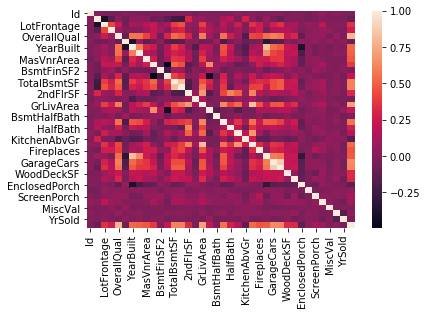

In [7]:
ax = sns.heatmap(df_numeric.corr())

#### Observe the value of non-numeric variables

In [8]:
df_nonNumeric = df.select_dtypes(include = ['object'])
df_nonNumeric_desc = df_nonNumeric.describe().T
df_nonNumeric_desc

count unique      top  freq
MSZoning       1460      5       RL  1151
Street         1460      2     Pave  1454
Alley            91      2     Grvl    50
LotShape       1460      4      Reg   925
LandContour    1460      4      Lvl  1311
Utilities      1460      2   AllPub  1459
LotConfig      1460      5   Inside  1052
LandSlope      1460      3      Gtl  1382
Neighborhood   1460     25    NAmes   225
Condition1     1460      9     Norm  1260
Condition2     1460      8     Norm  1445
BldgType       1460      5     1Fam  1220
HouseStyle     1460      8   1Story   726
RoofStyle      1460      6    Gable  1141
RoofMatl       1460      8  CompShg  1434
Exterior1st    1460     15  VinylSd   515
Exterior2nd    1460     16  VinylSd   504
MasVnrType     1452      4     None   864
ExterQual      1460      4       TA   906
ExterCond      1460      5       TA  1282
Foundation     1460      6    PConc   647
BsmtQual       1423      4       TA   649
BsmtCond       1423      4       TA  1311
BsmtExposure   1422      4       No   953
BsmtFinType1   1423      6      Unf   430
BsmtFinType2   1422      6      Unf  1256
Heating        1460      6     GasA  1428
HeatingQC      1460      5       Ex   741
CentralAir     1460      2        Y  1365
Electrical     1459      5    SBrkr  1334
KitchenQual    1460      4       TA   735
Functional     1460      7      Typ  1360
FireplaceQu     770      5       Gd   380
GarageType     1379      6   Attchd   870
GarageFinish   1379      3      Unf   605
GarageQual     1379      5       TA  1311
GarageCond     1379      5       TA  1326
PavedDrive     1460      3        Y  1340
PoolQC            7      3       Gd     3
Fence           281      4    MnPrv   157
MiscFeature      54      4     Shed    49
SaleType       1460      9       WD  1267
SaleCondition  1460      6   Normal  1198

#### Observe the relationship between non-numeric variables and SalePrice

In [9]:
# Tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [10]:
# for some reason tukeyhsd() doesn't work for CentralAir
df_nonNumeric2 = df_nonNumeric.drop(['CentralAir'], axis=1)
tukey_result = []
for col in df_nonNumeric2.columns:
    mc = MultiComparison(df['SalePrice'], df_nonNumeric[col].factorize()[0]) # use factorize to handel null values
    result = mc.tukeyhsd()
    tukey_result.append(sum(result.reject)) # get the number of pairs with significant difference

In [11]:
df_nonNumeric_desc = df_nonNumeric_desc.drop(['CentralAir'])
df_nonNumeric_desc['TukeyTest'] = tukey_result
df_nonNumeric_desc

count unique      top  freq  TukeyTest
MSZoning       1460      5       RL  1151          6
Street         1460      2     Pave  1454          0
Alley            91      2     Grvl    50          2
LotShape       1460      4      Reg   925          3
LandContour    1460      4      Lvl  1311          4
Utilities      1460      2   AllPub  1459          0
LotConfig      1460      5   Inside  1052          3
LandSlope      1460      3      Gtl  1382          0
Neighborhood   1460     25    NAmes   225        174
Condition1     1460      9     Norm  1260          4
Condition2     1460      8     Norm  1445          0
BldgType       1460      5     1Fam  1220          6
HouseStyle     1460      8   1Story   726          9
RoofStyle      1460      6    Gable  1141          2
RoofMatl       1460      8  CompShg  1434          3
Exterior1st    1460     15  VinylSd   515         17
Exterior2nd    1460     16  VinylSd   504         24
MasVnrType     1452      4     None   864          7
ExterQual      1460      4       TA   906          6
ExterCond      1460      5       TA  1282          2
Foundation     1460      6    PConc   647          4
BsmtQual       1423      4       TA   649          8
BsmtCond       1423      4       TA  1311          5
BsmtExposure   1422      4       No   953          9
BsmtFinType1   1423      6      Unf   430         13
BsmtFinType2   1422      6      Unf  1256          4
Heating        1460      6     GasA  1428          1
HeatingQC      1460      5       Ex   741          4
Electrical     1459      5    SBrkr  1334          2
KitchenQual    1460      4       TA   735          6
Functional     1460      7      Typ  1360          0
FireplaceQu     770      5       Gd   380         12
GarageType     1379      6   Attchd   870         11
GarageFinish   1379      3      Unf   605          6
GarageQual     1379      5       TA  1311          5
GarageCond     1379      5       TA  1326          3
PavedDrive     1460      3        Y  1340          2
PoolQC            7      3       Gd     3          3
Fence           281      4    MnPrv   157          2
MiscFeature      54      4     Shed    49          0
SaleType       1460      9       WD  1267          5
SaleCondition  1460      6   Normal  1198          6

In [12]:
# pair-wise test for CentralAir
from scipy import stats

In [13]:
f, p = stats.f_oneway(df.SalePrice[df.CentralAir == 'Y'],
                      df.SalePrice[df.CentralAir == 'N'])
print('p value:', p)

p value: 1.80950615593e-22


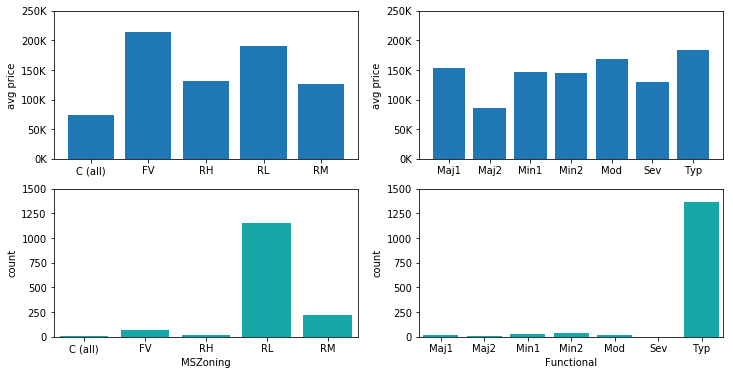

In [14]:
# Observe columns with and without significant pairs in TukeyTest
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
df1 = df[['MSZoning', 'SalePrice']].groupby('MSZoning').mean()
plt.bar(list(df1.index), df1['SalePrice'])
plt.ylabel('avg price')
plt.yticks((0, 50000, 100000, 150000, 200000, 250000), ('0K', '50K', '100K', '150K', '200K', '250K'))

plt.subplot(2,2,2)
df2 = df[['Functional', 'SalePrice']].groupby('Functional').mean()
plt.bar(list(df2.index), df2['SalePrice'])
plt.ylabel('avg price')
plt.yticks((0, 50000, 100000, 150000, 200000, 250000), ('0K', '50K', '100K', '150K', '200K', '250K'))

plt.subplot(2,2,3)
sns.countplot(df['MSZoning'], order=sorted(list(df['MSZoning'].unique())), color='c')
plt.ylim((0, 1500))

plt.subplot(2,2,4)
sns.countplot(df['Functional'], order=sorted(list(df['Functional'].unique())), color='c')
plt.ylim((0, 1500))

#plt.tight_layout()
plt.show()

The distribution is very unbalanced across non-numeric variables, even for those with significent differences. These variables won't be much helpful for modeling after being transferred to dummy columns. Therefore, only keep variables with enough sample sizes across categories and more than 1 pair of significance.

In [15]:
nonNumeric_cols_select = (
    df_nonNumeric_desc['count'] == 1460) & (
    df_nonNumeric_desc['freq'] <= 800) & (
    df_nonNumeric_desc['TukeyTest'] >= 2)
df_nonNumeric_desc[nonNumeric_cols_select]

count unique      top freq  TukeyTest
Neighborhood  1460     25    NAmes  225        174
HouseStyle    1460      8   1Story  726          9
Exterior1st   1460     15  VinylSd  515         17
Exterior2nd   1460     16  VinylSd  504         24
Foundation    1460      6    PConc  647          4
HeatingQC     1460      5       Ex  741          4
KitchenQual   1460      4       TA  735          6

#### Compare categories between train.csv and test.csv on selected nonNumeric columns
Compare files **train.csv** and **test.csv** to see if the selected non-numeric columns have the same set of categoreis.

In [16]:
# Apply lr model on 
df_test = pd.read_csv('../project-house-price-prediction/data/test.csv')
df_test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities      ...       ScreenPorch PoolArea PoolQC  Fence  \
0         Lvl    AllPub      ...               120        0    NaN  MnPrv   
1         Lvl    AllPub      ...                 0        0    NaN    NaN   
2         Lvl    AllPub      ...                 0        0    NaN  MnPrv   
3         Lvl    AllPub      ...                 0        0    NaN    NaN   
4         HLS    AllPub      ...               144        0    NaN    NaN   

  MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0      6    2010        WD         Normal  
1        Gar2   12500      6    2010        WD         Normal  
2         NaN       0      3    2010        WD         Normal  
3         NaN       0      6    2010        WD         Normal  
4         NaN       0      1    2010        WD         Normal  

[5 rows x 80 columns]

There are three columns having different sets of categories.

In [17]:
df_nonNumeric_desc_kaggle = df_test.select_dtypes(include = ['object']).drop('CentralAir', axis = 1).describe().T
df_compare = df_nonNumeric_desc.join(df_nonNumeric_desc_kaggle, 
                                     lsuffix = '_train',
                                     rsuffix = '_test')[nonNumeric_cols_select]
# Three selected nonNumeric columns have different numbers of categories between train.csv and test.csv
df_compare[df_compare['unique_train'] != df_compare['unique_test']]

count_train unique_train top_train freq_train  TukeyTest  \
HouseStyle         1460            8    1Story        726          9   
Exterior1st        1460           15   VinylSd        515         17   
Exterior2nd        1460           16   VinylSd        504         24   

            count_test unique_test top_test freq_test  
HouseStyle        1459           7   1Story       745  
Exterior1st       1458          13  VinylSd       510  
Exterior2nd       1458          15  VinylSd       510

Fortunately, the missing categories only account for a few instances. To avoid error at predicting step, remove the rows where the categories do not exist in **test.csv**.

In [18]:
for col in ['HouseStyle', 'Exterior1st', 'Exterior2nd']:
    print(pd.DataFrame(df[col].value_counts()).join(pd.DataFrame(df_test[col].value_counts()),
                                                    lsuffix = '_train', rsuffix = '_test'))

        HouseStyle_train  HouseStyle_test
1Story               726            745.0
2Story               445            427.0
1.5Fin               154            160.0
SLvl                  65             63.0
SFoyer                37             46.0
1.5Unf                14              5.0
2.5Unf                11             13.0
2.5Fin                 8              NaN
         Exterior1st_train  Exterior1st_test
VinylSd                515             510.0
HdBoard                222             220.0
MetalSd                220             230.0
Wd Sdng                206             205.0
Plywood                108             113.0
CemntBd                 61              65.0
BrkFace                 50              37.0
WdShing                 26              30.0
Stucco                  25              18.0
AsbShng                 20              24.0
BrkComm                  2               4.0
Stone                    2               NaN
AsphShn                  1           

#### Get the cleaned data set

In [19]:
# write function for it
def house_price_data_cleaning(data_frame, cols_to_drop, target_col=[]):
    """
    The function will take parameters of the data frame, columns to drop, and the target columns
    to incorporate all the data cleaning actions identified through data exploration
    and get the cleaned datasets, X and y, for modeling.
    """
    # Age of building/remodle from YearBuilt and YearRemodAdd
    data_frame['AgeBuilding'] = 2012 - data_frame['YearBuilt']
    data_frame['AgeRemodel'] = 2012 - data_frame['YearRemodAdd']
    
    # Remove categories not exist in test.csv
    df_filtered = data_frame[(data_frame['HouseStyle'] != '2.5Fin') &
                             (data_frame['Exterior1st'] != 'Stone') &
                             (data_frame['Exterior1st'] != 'ImStucc') &
                             (data_frame['Exterior2nd'] != 'Other')]
    
    # Drop numeric columns
    df_dropped = df_filtered.drop(cols_to_drop + target_col, axis=1)
    
    
    
    # Fill NA for numeric columns
    df_numeric = df_dropped.select_dtypes(include=['int64', 'float64']).apply(lambda x: x.fillna(x.mean()), axis=1)
    
    df_nonNumeric = df_dropped.select_dtypes(include=['object'])
    X = pd.concat([df_numeric, pd.get_dummies(df_nonNumeric)], axis=1)
    y = df_filtered[target_col]
    
    return X, y

In [20]:
drop_cols = ['Id', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 
             'TotalBsmtSF', 'TotRmsAbvGrd', 'MoSold', 'YrSold'
            ] + list(df_nonNumeric_desc[~nonNumeric_cols_select].index)
len(drop_cols)

43

In [21]:
X, y = house_price_data_cleaning(df, drop_cols, ['SalePrice'])
X.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  MasVnrArea  \
0        60.0         65.0   8450.0          7.0          5.0       196.0   
1        20.0         80.0   9600.0          6.0          8.0         0.0   
2        60.0         68.0  11250.0          7.0          5.0       162.0   
3        70.0         60.0   9550.0          7.0          5.0         0.0   
4        60.0         84.0  14260.0          8.0          5.0       350.0   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  1stFlrSF       ...        HeatingQC_Fa  \
0       706.0         0.0      150.0     856.0       ...                   0   
1       978.0         0.0      284.0    1262.0       ...                   0   
2       486.0         0.0      434.0     920.0       ...                   0   
3       216.0         0.0      540.0     961.0       ...                   0   
4       655.0         0.0      490.0    1145.0       ...                   0   

   HeatingQC_Gd  HeatingQC_Po  HeatingQC_TA  CentralAir_N  CentralAir_Y  \
0             0             0             0             0             1   
1             0             0             0             0             1   
2             0             0             0             0             1   
3             1             0             0             0             1   
4             0             0             0             0             1   

   KitchenQual_Ex  KitchenQual_Fa  KitchenQual_Gd  KitchenQual_TA  
0               0               0               1               0  
1               0               0               0               1  
2               0               0               1               0  
3               0               0               1               0  
4               0               0               1               0  

[5 rows x 108 columns]

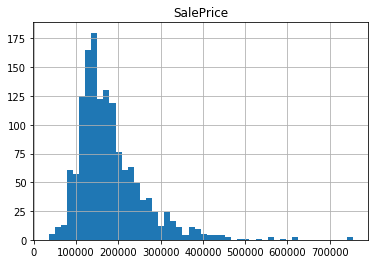

In [22]:
y.hist(bins=50)
plt.show()

<a id = "sklearn"></a>
## Modeling

### Linear Regression

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("R-squared:", lr.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R-squared: 0.860053577106
RMSE: 25458.4020583


In [25]:
# Cross-validation result
lr_cross = LinearRegression()
cv_results = cross_val_score(lr_cross, X, y, cv=5)
cv_results

array([ 0.89591104,  0.83168165,  0.83208257,  0.8326819 ,  0.69913928])

### Interpreting the coefficient of linear regression
If the purpose of builing linear regression models is for interpretation. The package `statsmodels.api` would be a better option then the package `sklearn` for providing coefficients with p-value.

In [26]:
import statsmodels.api as sm

In [27]:
X_sm = sm.add_constant(X)
lr_sm = sm.OLS(y, X_sm)
lr_sm = lr_sm.fit()
print(lr_sm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     87.07
Date:                Wed, 04 Sep 2019   Prob (F-statistic):               0.00
Time:                        20:37:47   Log-Likelihood:                -16944.
No. Observations:                1448   AIC:                         3.409e+04
Df Residuals:                    1349   BIC:                         3.461e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3640.1388 

### Ridge Regression

In [28]:
from sklearn.linear_model import Ridge

In [29]:
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

print("R-squared:", ridge.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R-squared: 0.870479704735
RMSE: 24491.712499


### Sparse Regression

In [30]:
from sklearn.linear_model import Lasso

In [67]:
lasso = Lasso(alpha = 10, normalize=True)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print("R-squared:", lasso.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R-squared: 0.867464525362
RMSE: 24775.1509196


### Elastic Net

In [69]:
from sklearn.linear_model import ElasticNet

In [97]:
elastic_net = ElasticNet(alpha = 0.01, l1_ratio = 0.01)
elastic_net.fit(X_train, y_train)
y_pred = elastic_net.predict(X_test)
print("R-squared:", elastic_net.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R-squared: 0.871459753402
RMSE: 24398.8751214


c:\users\byron\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Coefficients

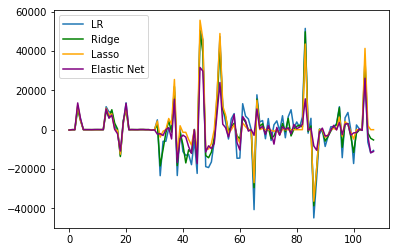

In [106]:
fig, ax = plt.subplots()
ax.plot(lr.coef_.squeeze(), label='LR')
ax.plot(ridge.coef_.squeeze(), color = 'green', label='Ridge')
ax.plot(lasso.coef_, color = 'orange', label='Lasso')
ax.plot(elastic_net.coef_, color = 'purple', label='Elastic Net')
leg = ax.legend();

### Grid Search

In [109]:
from sklearn.model_selection import GridSearchCV

In [121]:
alpha_space = np.linspace(0, 1, 101)
param_grid = {'alpha': alpha_space}
ridge = Ridge(normalize=True)
gm_cv = GridSearchCV(ridge, param_grid, cv=6)
gm_cv.fit(X_train, y_train)
print(gm_cv.best_params_, gm_cv.best_score_)

{'alpha': 0.60999999999999999} 0.776947147086


In [114]:
np.linspace(0, 1, 101)

array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
        0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
        0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
        0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
        0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
        0.54,  0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,
        0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,
        0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,
        0.81,  0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,
        0.9 ,  0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,
        0.99,  1.  ])

In [122]:
y_pred = gm_cv.predict(X_test)
print('R-squared: {}, RMSE: {}'.format(gm_cv.score(X_test,y_test), np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared: 0.8738706436116395, RMSE: 24168.980407623654


### Other Models
boostrap, bagging, random forest, boosting

In [108]:
from sklearn.ensemble import RandomForestRegressor

<a id = "conclusion"></a>
## Performance & Conclusion

In [99]:
X_test_kaggle, y_test_kaggle = house_price_data_cleaning(df_test, drop_cols)
lr_kaggle = LinearRegression()
lr_kaggle.fit(X, y)
y_pred_kaggle = lr_kaggle.predict(X_test_kaggle)
y_pred_kaggle

array([[ 116384.01574647],
       [ 158760.01461952],
       [ 175540.3231846 ],
       ..., 
       [ 181877.81006835],
       [  93139.64124942],
       [ 220235.59814217]])

In [177]:
# Kaggle score 0.21015; Rank 3817
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                             index=False)

In [35]:
# Kaggle score 0.19031; Rank 3619
ridge_kaggle = Ridge(alpha=0.5, normalize=True)
ridge_kaggle.fit(X, y)
y_pred_kaggle = ridge_kaggle.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                              index=False)

In [100]:
# Worse performance than Ridge Regression
elastic_net_kaggle = ElasticNet(alpha=0.01, l1_ratio=0.1)
elastic_net_kaggle.fit(X, y)
y_pred_kaggle = elastic_net_kaggle.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                              index=False)

c:\users\byron\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [124]:
# 0.18998; Rank 3587
alpha_space = np.linspace(0, 1, 101)
param_grid = {'alpha': alpha_space}
ridge = Ridge(normalize=True)
gm_cv = GridSearchCV(ridge, param_grid, cv=6)
gm_cv.fit(X, y)
y_pred_kaggle = gm_cv.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                              index=False)